In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [75]:
df = pd.read_csv('analytics_test.csv')

In [76]:
print(df.head())

   Unnamed: 0   user_id     sex  age    platform  query_id  \
0           0  96422511  female   68     android  89656828   
1           1  45247030    male   62  android_tv  89784877   
2           2  79572413    male   12         web  10555855   
3           3    821317  female   58  android_tv  72054848   
4           4   6206023  female   24     android  20838049   

                       query_text query_type      event  click_position  \
0    передачи о новых технологиях       show      share               6   
1               автопрому новости       news     search               0   
2  логистическое законодательство       news     search               0   
3       банковские премии новости       news     search               0   
4                 вики шоу аманда       show  subscribe               7   

   doc_type  view_time  
0  playlist          0  
1       NaN          0  
2       NaN          0  
3       NaN          0  
4    author          0  


In [77]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      20000 non-null  int64 
 1   user_id         20000 non-null  int64 
 2   sex             20000 non-null  object
 3   age             20000 non-null  int64 
 4   platform        20000 non-null  object
 5   query_id        20000 non-null  int64 
 6   query_text      20000 non-null  object
 7   query_type      20000 non-null  object
 8   event           20000 non-null  object
 9   click_position  20000 non-null  int64 
 10  doc_type        15042 non-null  object
 11  view_time       20000 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 1.8+ MB
None


### Предобработка

In [78]:
#на всякий случай приведем к нижнему регистру

df['query_text'] = df['query_text'].str.lower()
df['query_type'] = df['query_type'].str.lower()
df['event'] = df['event'].str.lower()
df['doc_type'] = df['doc_type'].str.lower()

In [79]:
df['doc_type'] = df['doc_type'].fillna('unknown')

In [80]:
df = df[df['view_time'] >= 0]

In [81]:
df['click_position'] = pd.to_numeric(df['click_position'], errors='coerce').fillna(-1).astype(int)

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      20000 non-null  int64 
 1   user_id         20000 non-null  int64 
 2   sex             20000 non-null  object
 3   age             20000 non-null  int64 
 4   platform        20000 non-null  object
 5   query_id        20000 non-null  int64 
 6   query_text      20000 non-null  object
 7   query_type      20000 non-null  object
 8   event           20000 non-null  object
 9   click_position  20000 non-null  int64 
 10  doc_type        20000 non-null  object
 11  view_time       20000 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 1.8+ MB


### Метрики

### По Query_type

In [98]:
import pandas as pd

metrics = []

query_types = df['query_type'].dropna().unique()

for q_type in query_types:
    q_ids = df[(df['event'] == 'search') & (df['query_type'] == q_type)]['query_id'].unique()
    
    if len(q_ids) == 0:
        continue  
    
    related_events = df[df['query_id'].isin(q_ids)]

    ctr = related_events[related_events['event'] == 'tap']['query_id'].nunique() / len(q_ids)
    view_rate = related_events[related_events['event'] == 'view']['query_id'].nunique() / len(q_ids)


    metrics.append({
        'query_type': q_type,
        'CTR': ctr,
        'View Rate': view_rate,
    })

metrics_df = pd.DataFrame(metrics)
print(metrics_df.sort_values(by='CTR', ascending=False))


  query_type       CTR  View Rate
0       show  0.038678   0.012893
2      music  0.028525   0.010595
1       news  0.025974   0.004870
3      films  0.000000   0.000000


Получились странные метрики для "films", поэтому я решила рассмотреть их подробнее

In [84]:
films_search_ids = df[(df['query_type'] == 'films') & (df['event'] == 'search')]['query_id'].unique()
print(f"Поисков типа 'films': {len(films_search_ids)}")


Поисков типа 'films': 1258


In [85]:
films_all_events = df[df['query_id'].isin(films_search_ids)]
print(f"Всего событий по этим запросам: {len(films_all_events)}")
print(films_all_events['event'].value_counts())


Всего событий по этим запросам: 1258
event
search    1258
Name: count, dtype: int64


Теперь можно объяснить странные метрики, ибо пользователи не смотрели и не кликали ничего после поиска по категории фильмов. Это явный сигнал о низком качестве выдачи или нерелевантности.

### По Платформам

In [99]:
platforms = df['platform'].unique()
platform_metrics = []

for plat in platforms:
    sub = df[df['platform'] == plat]
    searches = sub[sub['event'] == 'search']['query_id'].unique()
    taps = sub[(sub['event'] == 'tap') & (sub['query_id'].isin(searches))]['query_id'].unique()
    views = sub[(sub['event'] == 'view') & (sub['query_id'].isin(searches))]['query_id'].unique()
    actions = sub[(sub['event'] != 'search') & (sub['query_id'].isin(searches))]['query_id'].unique()

    platform_metrics.append({
        'platform': plat,
        'CTR': len(taps) / len(searches) if searches.size > 0 else 0,
        'View Rate': len(views) / len(searches) if searches.size > 0 else 0,
    })

platform_df = pd.DataFrame(platform_metrics)
print(platform_df.sort_values('CTR'))


     platform       CTR  View Rate
2         web  0.004071   0.000000
1  android_tv  0.005123   0.002049
3    smart_tv  0.006731   0.001923
0     android  0.008040   0.000000
4      iphone  0.010256   0.004103


### Посчитаем Bounce Rate для разных факторов

### По возрасту

In [101]:
df['age_group'] = pd.cut(df['age'], bins=[0, 17, 24, 34, 44, 54, 64, 100],
                         labels=['<18', '18-24', '25-34', '35-44', '45-54', '55-64', '65+'])

age_metrics = []

for group in df['age_group'].unique():
    sub = df[df['age_group'] == group]
    searches = sub[sub['event'] == 'search']['query_id'].unique()
    taps = sub[(sub['event'] == 'tap') & (sub['query_id'].isin(searches))]['query_id'].unique()
    views = sub[(sub['event'] == 'view') & (sub['query_id'].isin(searches))]['query_id'].unique()
    actions = sub[(sub['event'] != 'search') & (sub['query_id'].isin(searches))]['query_id'].unique()

    age_metrics.append({
        'age_group': group,
        'CTR': len(taps) / len(searches) if searches.size > 0 else 0,
        'View Rate': len(views) / len(searches) if searches.size > 0 else 0,
    })

age_df = pd.DataFrame(age_metrics)
print(age_df.sort_values('CTR'))


  age_group       CTR  View Rate
4       NaN  0.000000   0.000000
3     18-24  0.009569   0.004785
5     25-34  0.012238   0.008741
6     35-44  0.016978   0.000000
7     45-54  0.017825   0.005348
0       65+  0.018868   0.003145
1     55-64  0.020570   0.003165
2       <18  0.021413   0.000000


Молодые(<18) и возрастные(55+) кликают немного чаще, но всё равно вовлечённость низкая.


In [102]:
session = (
    df.groupby('query_id')
      .agg(
        query_type    = ('query_type',  'first'),
        platform      = ('platform',    'first'),
        age           = ('age',         'first'),
        has_tap       = ('event',       lambda ev: 'tap' in set(ev)),
        has_view      = ('event',       lambda ev: 'view' in set(ev)),
        has_deep      = ('event',       lambda ev: bool({'like','share','subscribe'} & set(ev))),
        max_view_time = ('view_time',   'max')
      )
      .reset_index()
)

bins   = [0, 17, 24, 34, 44, 54, 64, 100]
labels = ['<18','18-24','25-34','35-44','45-54','55-64','65+']
session['age_bucket'] = pd.cut(session['age'], bins=bins, labels=labels, right=True)

session['bounce'] = (~session['has_tap']) & (session['max_view_time'] <= 5)

for dim in ['query_type','platform','age_bucket']:
    br = (session.groupby(dim)['bounce']
                 .mean()
                 .mul(100)
                 .round(1)
                 .sort_values(ascending=False))
    print(f"\nBounce‑rate по {dim} (в %):\n", br)


Bounce‑rate по query_type (в %):
 query_type
show     58.1
music    52.9
films    48.5
news     43.3
Name: bounce, dtype: float64

Bounce‑rate по platform (в %):
 platform
android       53.0
web           52.3
iphone        52.1
android_tv    48.5
smart_tv      47.1
Name: bounce, dtype: float64

Bounce‑rate по age_bucket (в %):
 age_bucket
18-24    52.3
25-34    52.3
65+      51.8
35-44    50.9
<18      50.4
45-54    49.7
55-64    49.7
Name: bounce, dtype: float64


/tmp/ipykernel_40437/1856867220.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  br = (session.groupby(dim)['bounce']


Более половины пользователей после поиска по шоу ни кликают, ни просматривают видео > 5 с. Разброс по платформам невелик (~6 п.п.), значит основная проблема — алгоритм выдачи и контент, а не конкретный UI. Аудитория 18–34 «сыпется» чаще всего — стоит протестировать для них персонализированную выдачу, добавить фильтры по жанрам/новизне и более яркие превью.


Среднее view_time по квантилям длины запроса:
   len_bin    view_time
0      Q1  3386.185759
1      Q2  3992.407806
2      Q3  4104.709962
3      Q4  5287.944218


/tmp/ipykernel_40437/981604961.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('len_bin')['view_time']


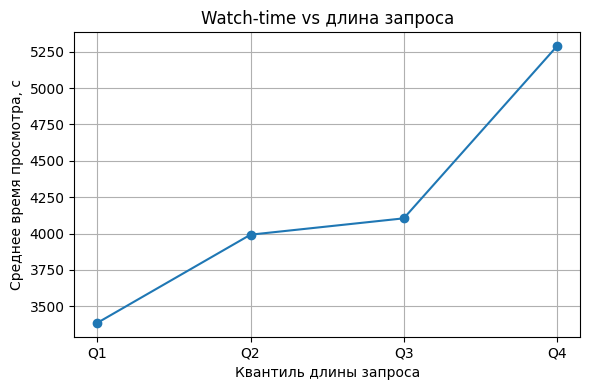

In [ ]:
df['query_len'] = df['query_text'].str.len()
qtiles = df[df['event']=='search']['query_len'].quantile([0,0.25,0.5,0.75,1]).values
df['len_bin'] = pd.cut(
    df['query_len'], bins=qtiles, include_lowest=True,
    labels=['Q1','Q2','Q3','Q4']
)

view_by_len = (
    df[df['event']=='view']
      .groupby('len_bin')['view_time']
      .mean()
      .reset_index()
)

print("\nСреднее view_time по квантилям длины запроса:\n", view_by_len)

plt.figure(figsize=(6,4))
plt.plot(view_by_len['len_bin'], view_by_len['view_time'], marker='o')
plt.xlabel('Квантиль длины запроса')
plt.ylabel('Среднее время просмотра, с')
plt.title('Watch‑time vs длина запроса')
plt.grid(True)
plt.tight_layout()
plt.show()

Можно заметить, что длинные запросы дают наиболее глубокое вовлечение

### Визуализация

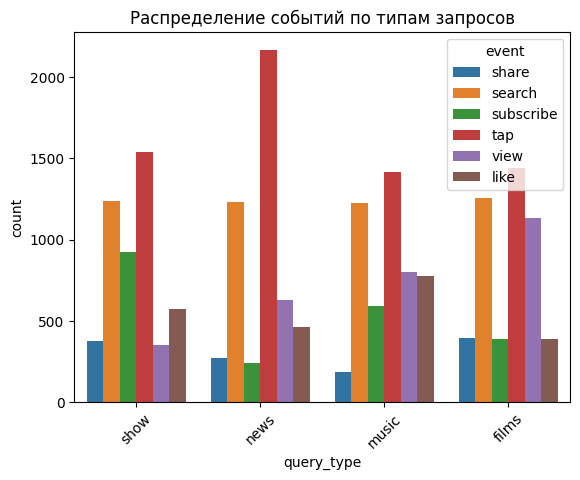

In [89]:
sns.countplot(data=df, x='query_type', hue='event')
plt.title('Распределение событий по типам запросов')
plt.xticks(rotation=45)
plt.show()


Все query_type имеют сопоставимое количество search событий. Также можно заметить высокий view в films, но почти без tap (о чем нам и говорят метрики посчитанные выше) Возможно нет кликабельного контента в выдаче после просмотра видео или Неправильный мэтчинг запросов.

### Небольшая запросная аналитика по films

In [90]:
# топ самых частых запросов

films_df = df[df['query_type'] == 'films']
top_queries = films_df[films_df['event'] == 'search']['query_text'].value_counts().head(20)
print(top_queries)


query_text
альтернативные концовки известных фильмов         25
фильмы про искусственный интеллект                23
фильмы, снятые в париже                           23
самые низкооцененные фильмы на rotten tomatoes    23
документальные фильмы про природу                 22
русские фильмы про войну                          22
золотой глобус номинанты                          21
ужасы с высоким рейтингом                         21
топ 10 сериалов этого года                        21
исполнители ролей в 'игре престолов'              20
актеры из фильмов марвел                          20
как выбрать проектор для дома                     20
документалки, получившие оскар                    19
совпадения в киновселенных                        19
все фильмы кристофера нолана                      18
саундтреки ханса циммера                          18
фильмы, которые изменили киноиндустрию            17
новинки кино 2024                                 17
фильмы в vr-формате                

In [91]:
top_query_texts = top_queries.index.tolist()
films_top_df = films_df[films_df['query_text'].isin(top_query_texts)]

actions_by_query = (
    films_top_df
    .groupby(['query_text', 'event'])['query_id']
    .count()
    .unstack(fill_value=0)
    .reset_index()
)

search_counts = actions_by_query['search'] + 1e-9

actions_by_query['CTR'] = actions_by_query['tap'] / search_counts
actions_by_query['View Rate'] = actions_by_query['view'] / search_counts

engaged = actions_by_query['tap'] + actions_by_query['view']
actions_by_query['Bounce Rate'] = (1 - engaged / search_counts).clip(lower=0, upper=1)

actions_by_query = actions_by_query.sort_values(by='search', ascending=False)
actions_by_query.head(15)


event,query_text,like,search,share,subscribe,tap,view,CTR,View Rate,Bounce Rate
1,альтернативные концовки известных фильмов,3,25,8,4,16,9,0.640000,0.360000,4.000000e-11
19,"фильмы, снятые в париже",2,23,4,5,11,8,0.478261,0.347826,1.739130e-01
17,фильмы про искусственный интеллект,6,23,3,5,17,17,0.739130,0.739130,0.000000e+00
11,самые низкооцененные фильмы на rotten tomatoes,6,23,5,5,20,17,0.869565,0.739130,0.000000e+00
10,русские фильмы про войну,4,22,7,3,15,15,0.681818,0.681818,0.000000e+00
4,документальные фильмы про природу,3,22,4,5,17,21,0.772727,0.954545,0.000000e+00
6,золотой глобус номинанты,7,21,4,4,14,13,0.666667,0.619048,0.000000e+00
14,топ 10 сериалов этого года,4,21,3,3,5,11,0.238095,0.523810,2.380952e-01
15,ужасы с высоким рейтингом,4,21,2,3,18,13,0.857143,0.619048,0.000000e+00
7,исполнители ролей в 'игре престолов',3,20,4,5,19,12,0.950000,0.600000,0.000000e+00


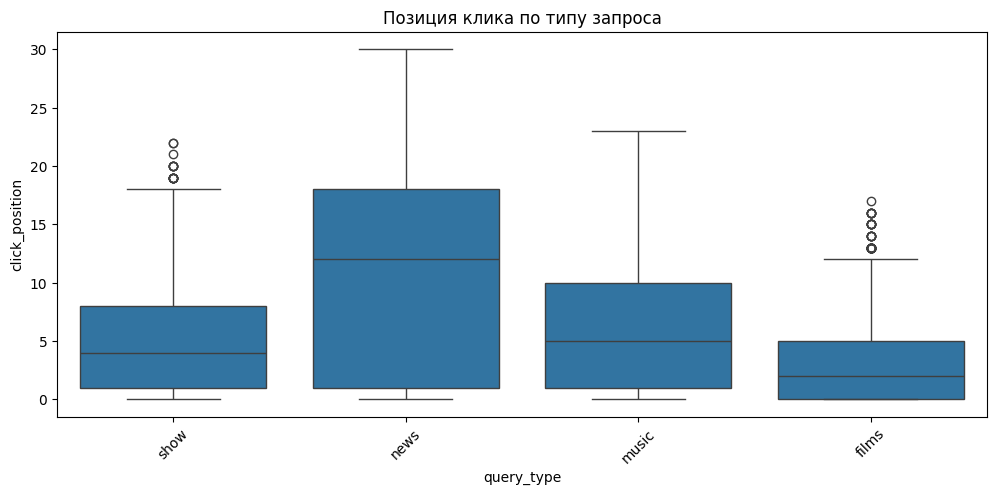

In [93]:
plt.figure(figsize=(12, 5))

sns.boxplot(data=df, x='query_type', y='click_position')
plt.title('Позиция клика по типу запроса')
plt.xticks(rotation=45)
plt.show()




Фильмы и шоу получают клики в более начальных позициях. Новости — наиболее «глубоко» прокручиваемый тип контента (медиана ~12, максимальный размах). У фильмов и шоу есть выбросы, что может говорить о более редком интересе к менее релевантным результатам.



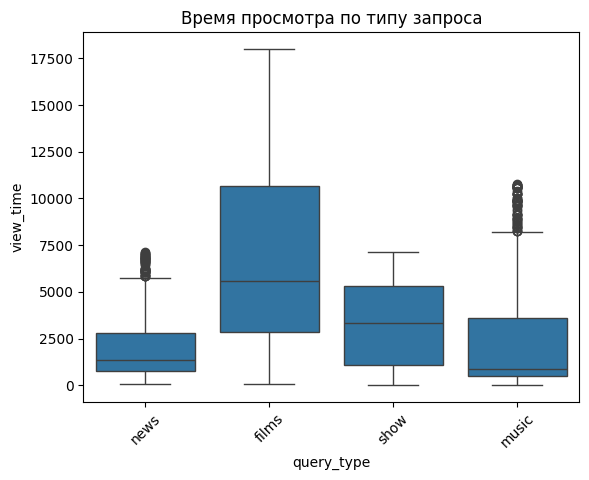

In [94]:

sns.boxplot(data=df[df['event'] == 'view'], x='query_type', y='view_time')
plt.title('Время просмотра по типу запроса')
plt.xticks(rotation=45)
plt.show()

Фильмы — абсолютные лидеры по продолжительности просмотра.Новости — самый краткий тип потребления, возможно, пользователи читают заголовки или краткие материалы. У музыки и новостей заметны выбросы — кто-то может слушать/смотреть долго, но это скорее исключения.



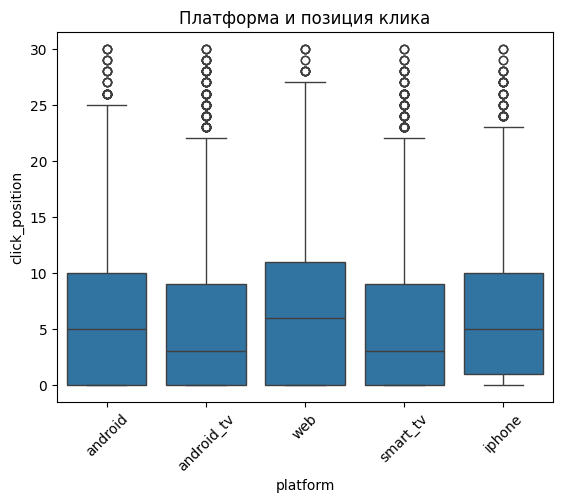

In [96]:
sns.boxplot(data=df, x='platform', y='click_position')
plt.title('Платформа и позиция клика')
plt.xticks(rotation=45)
plt.show()


TV-платформы (android_tv, smart_tv) — пользователи кликают на первые результаты. Web-пользователи — кликают глубже, возможно, из-за удобства прокрутки и более широкого экрана. Мобильные платформы (android, iphone): клики в пределах первых 5–10 позиций.



### Выводы



### 1. Сводная картина вовлеченности

| Метрика                   | Значение                                    |
|---------------------------|---------------------------------------------|
| Средний CTR (tap/search)  | < 1 % (0.4–1.0 %) для большинства сегментов |
| Средний Bounce‑rate       | 43–58 % в зависимости от категории запросов  |
| Среднее time‑on‑site (view) | 56–88 мин в зависимости от длины запроса  |
| Среднее позиция клика     | 7–8                                        |

---

### 2. Проблемные зоны

1. **Категории запросов**  
   - **Show (58 % bounce)** и **Music (53 %)** — худшие по «отскоку».  
   - **Films**: 1 258 поисков и **0 кликов/просмотров** за сессию → явная проблема таргетинга или маппинга запросов.

2. **Платформы**  
   - На **Android** и **Web** bounce ≈ 52–53 %.  
   - Разница между мобильными и TV‑платформами не превышает 6 п.п. ⇒ основная беда в выдаче и превью.

3. **Возрастные группы**  
   - Наиболее «отскакивают» **18–24** и **25–34** (52.3 %).  
   - Старшие и дети чуть лучше (≈50 %), но тоже далеко от идеала.

4. **Длина запроса**  
   - **Q1 (короткие)**: 3 386 с средний view_time.  
   - **Q4 (длинные)**: 5 288 с.  
   - короткие, неинформативные запросы дают самое слабое удержание.


---

### 3. Точки роста и рекомендации

1. **Улучшить релевантность ранжирования**  

2. **Оптимизировать UX коротких запросов**  

3. **Фокус на категориях Show и Music**  

4. **Персонализация для аудитории 18–34**  
